In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import bomi

In [3]:
%aimport bomi

In [4]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Initial board analysis and filtering

In [5]:
import os

all = []
for file in os.listdir("../CSVs-completos"):
    df = pd.read_csv(f"../CSVs-completos/{file}", index_col=0, parse_dates=["date"], low_memory=False)
    info = bomi.log_info(df)
    

    info['name'] = file
    all.append(info)

result = pd.DataFrame.from_records(pd.json_normalize(all))
result['board_duration'] = (result['ends'] - result['start'])
result.head(10)


/var/folders/zh/rsnvvr_n1mb7392grd9yhnlw0000gn/T/ipykernel_54683/2147758899.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f"../CSVs-completos/{file}", index_col=0, parse_dates=["date"], low_memory=False)
/var/folders/zh/rsnvvr_n1mb7392grd9yhnlw0000gn/T/ipykernel_54683/2147758899.py:12: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  result = pd.DataFrame.from_records(pd.json_normalize(all))


,events,attribs,cards,lists,list_first_create,list_last_create,list_renamed,list_closed,start,ends,board_duration,first_event_type,members,card_members_assigned,card_checklists,card_movement,card_closed,card_deleted,card_due,cards_moving_perc,cards_checklist_perc,cards_assigned_perc,cards_closed_perc,name,events_per_member.count,events_per_member.mean,events_per_member.std,events_per_member.min,events_per_member.25%,events_per_member.50%,events_per_member.75%,events_per_member.max
0,81,60,27,6,2021-06-14 12:44:10.078000+00:00,2021-06-14 12:46:09.995000+00:00,6,0,2021-06-14 12:43:56.409000+00:00,2021-12-15 21:40:01.708000+00:00,184 days 08:56:05.299000,createBoard,8,1,0,1,8,0,0,0.037037,0.000000,0.037037,0.296296,Merseyside Fire & Rescue Training and Educatio...,8.0,10.125000,23.805387,1.0,1.0,1.5,3.00,69.0
1,406,63,22,4,2020-03-13 15:11:57.480000+00:00,2020-03-13 18:59:19.085000+00:00,0,0,2020-03-13 15:11:57.244000+00:00,2020-12-14 08:25:17.625000+00:00,275 days 17:13:20.381000,createBoard,2,147,1,11,0,1,0,0.409091,0.045455,0.272727,0.000000,speleo.se.csv,2.0,203.000000,203.646753,59.0,131.0,203.0,275.00,347.0
2,354,82,125,3,NaT,NaT,0,0,2015-12-08 07:33:46.311000+00:00,2021-11-07 04:34:09.882000+00:00,2160 days 21:00:23.571000,copyCommentCard,17,1,0,2,0,10,0,0.008000,0.000000,0.008000,0.000000,浙江任务.csv,17.0,20.823529,48.923710,1.0,1.0,1.0,2.00,164.0
3,89,48,28,5,2021-10-18 08:11:46.005000+00:00,2021-11-24 18:50:58.565000+00:00,0,0,2021-10-18 08:11:37.087000+00:00,2022-01-11 22:16:29.013000+00:00,85 days 14:04:51.926000,createBoard,3,0,1,18,2,0,0,0.464286,0.035714,0.000000,0.071429,Iishee orooroi.csv,3.0,29.666667,21.939310,5.0,21.0,37.0,42.00,47.0
4,48905,103,8847,686,2020-05-14 00:23:03.192000+00:00,2022-03-02 05:01:58.050000+00:00,213,856,2020-05-13 23:55:03.489000+00:00,2022-03-02 12:14:56.338000+00:00,657 days 12:19:52.849000,createBoard,193,63,10,10026,114,89,11,0.778456,0.000904,0.004973,0.012886,Session Board.csv,193.0,253.393782,616.934112,1.0,12.0,43.0,203.00,4939.0
5,428,76,85,23,2021-06-18 08:32:43.413000+00:00,2021-06-30 06:59:56.545000+00:00,30,14,2021-06-18 08:31:56.467000+00:00,2021-07-22 06:43:07.884000+00:00,33 days 22:11:11.417000,createBoard,1,0,0,5,2,22,5,0.047059,0.000000,0.000000,0.023529,Kenobisboch.csv,1.0,428.000000,NaN,428.0,428.0,428.0,428.00,428.0
6,101,50,18,4,2021-06-19 04:50:58.956000+00:00,2021-08-27 05:23:22.425000+00:00,3,0,2021-06-19 04:49:38.125000+00:00,2021-12-06 04:03:54.781000+00:00,169 days 23:14:16.656000,createBoard,1,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,Trisciatha.csv,1.0,101.000000,NaN,101.0,101.0,101.0,101.00,101.0
7,61,28,24,6,2015-01-19 19:17:44.720000+00:00,2015-01-19 19:18:24.562000+00:00,0,0,2015-01-19 19:16:51.749000+00:00,2015-02-03 05:57:05.884000+00:00,14 days 10:40:14.135000,createBoard,1,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,OKRs.csv,1.0,61.000000,NaN,61.0,61.0,61.0,61.00,61.0
8,397,45,149,39,2021-12-25 02:43:56.049000+00:00,2022-01-01 22:13:08.636000+00:00,12,19,2021-12-25 02:35:58.555000+00:00,2022-01-22 16:17:46.435000+00:00,28 days 13:41:47.880000,createBoard,1,0,0,0,5,0,0,0.000000,0.000000,0.000000,0.033557,Deepwoken.csv,1.0,397.000000,NaN,397.0,397.0,397.0,397.00,397.0
9,3855,120,393,18,2021-06-08 12:08:21.427000+00:00,2022-02-14 13:43:53.549000+00:00,3,11,2021-04-02 22:49:02.742000+00:00,2022-02-25 13:06:25.526000+00:00,328 days 14:17:22.784000,createBoard,26,37,16,221,120,26,26,0.348601,0.025445,0.076336,0.305344,Navy Seals.csv,26.0,148.269231,256.326442,1.0,3.0,48.0,147.25,1011.0


In [6]:
# The first event of the boards. 
result["first_event_type"].value_counts()

first_event_type
createBoard        488
copyBoard           91
createCard          20
copyCommentCard     12
updateCard           3
addMemberToCard      1
commentCard          1
Name: count, dtype: int64

We will discard all of those that do not start with createBoard. The others might have had problems when they were extracted or they were copied from a previously created board and, in that case, we will be missing information

In [7]:
result_f = result[result["first_event_type"]=="createBoard"]

Now, we analyze the distributions of events, cards and lists to get an idea of how the collection of boards look like

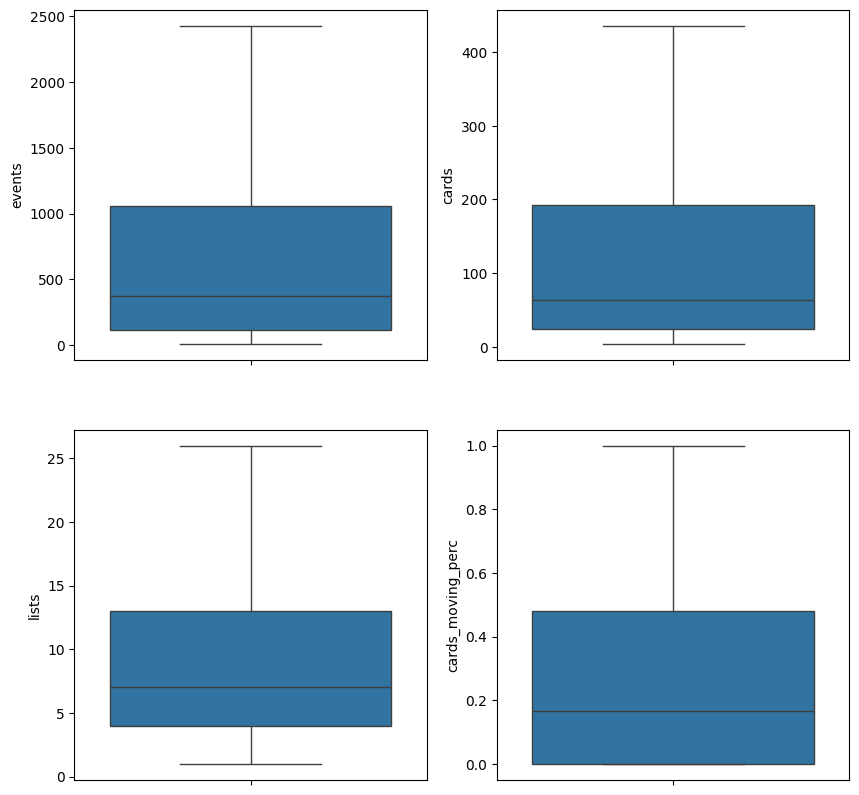

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

axf = ax.flatten()
for i, at in enumerate(['events', 'cards', 'lists', 'cards_moving_perc']):
    sns.boxplot(y=at, data=result_f, showfliers=False, ax=axf[i])


In [9]:
result_f[["events", "cards", "lists", "cards_moving_perc", "cards_closed_perc"]].describe()

,events,cards,lists,cards_moving_perc,cards_closed_perc
count,488.000000,488.000000,488.000000,488.000000,488.000000
mean,1560.909836,215.127049,12.633197,0.271170,0.124358
std,6086.940249,743.618825,35.351603,0.291105,0.188189
min,11.000000,4.000000,1.000000,0.000000,0.000000
25%,118.500000,24.000000,4.000000,0.000000,0.000000
50%,377.000000,63.500000,7.000000,0.164966,0.042471
75%,1059.500000,192.250000,13.000000,0.479663,0.166667
max,103250.000000,10809.000000,686.000000,1.000000,0.928315


Let's filter only those that have had a minimum use. We determine that based on the board lifetime and the number of events

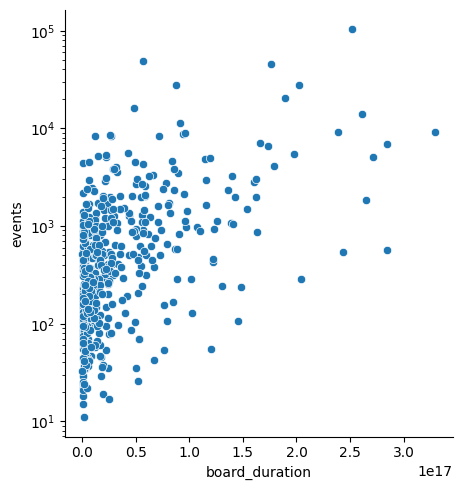

In [10]:
g = sns.relplot(x='board_duration', y='events', data=result_f)
g.set(yscale="log")

In our analysis, we will select only those boards that have had more than 2000 events and has been used for more than 12 weeks.

In [11]:
selected = result_f[(result_f['events'] > 2000)  & ((result_f['ends'] - result_f['start']) > pd.Timedelta('12W'))]
selected.shape

(63, 32)

In [12]:
selected["name"].values

array(['Session Board.csv', 'Navy Seals.csv',
       'Subnautica Development.csv', 'DevDocs Documentation.csv',
       'Rogue Lineage.csv', 'Tatakai.csv', 'a.csv', 'lovedrop lake.csv',
       'treachery.online.csv', 'Teardown Tracker.csv',
       '[MG] Mediziner.csv', 'Deisim Development.csv',
       'Project Aincrad.csv', 'Skin Approval.csv', 'Last Pirates .csv',
       'Resurgence.csv', "Rikudou's Addons.csv", 'VH3.csv',
       'Wayward Todo.csv', 'HKSTP TalentConnect.csv',
       'An Uprising Trello.csv', 'PnP.csv', '近期待辦事項.csv', 'Lishting.csv',
       'Software Inc..csv', 'Aeronautica (Discontinued Trello).csv',
       'GTA Colors.csv', 'RPG Resources.csv', 'VulgarLang.csv',
       '(Antigo)PokeZWorld.csv', 'Oeagag Trello.csv', 'Animes.csv',
       'SoulShatters.csv', 'Studiocart Roadmap.csv', 'Content Team.csv',
       'Inbox.csv', 'Territory Helper.csv', '#BergShelterPets.csv',
       'Svnnydraw.csv', 'Divine.csv', 'R2CK.csv', 'Supa VAM.csv',
       'Elation.csv', 'SEEL 2021-II (

In [13]:
# Use this for additional filters
#sel = selected[selected["cards_moving_perc"] >0.6]
sel = selected
sel.shape

(63, 32)

# Detailed board evolution analysis

Now, we will analyze in detail the selected boards

In [14]:
all = []
all_redesigns = []
all_names = []
all_between = []
all_duration = []
all_board_interval = []
for file in sel["name"]:
    df = pd.read_csv(f"../CSVs-completos/{file}", index_col=0, parse_dates=["date"], low_memory=False)
    bomi.enrich_log(df)
    redesigns = bomi.detect_redesign(df, pd.Timedelta('1D'), threshold_l_events=0)
    all_redesigns.append(redesigns)
    all_between.append(pd.concat([redesigns['min'].shift(1).fillna(max(df['date'])), redesigns['max']], axis=1))
    all_names.append(file)
    all_duration.append((max(df['date']) - min(df['date'])))
    all_board_interval.append((max(df['date']), min(df['date'])))


/Users/resinas/Projects/board-mining/trello-logs/board-mining/bomi.py:119: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[df["data.list.closed"].infer_objects(copy=False).fillna(False), 'l'] = "list_ends"
/Users/resinas/Projects/board-mining/trello-logs/board-mining/bomi.py:142: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df["data.card.closed"].infer_objects(copy=False).fillna(False)
/Users/resinas/Projects/board-mining/trello-logs/board-mining/bomi.py:119: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprec

In [15]:
all_descriptions = []
for n, between_red, dur in zip(all_names, all_between, all_duration):
    dd = ((between_red['min'] - between_red['max']) /dur).describe()
    dd.name = n
    all_descriptions.append(dd)

redesigns_description = pd.concat(all_descriptions, axis=1).T
redesigns_description
    

,count,mean,std,min,25%,50%,75%,max
Session Board.csv,185.0,0.000940,0.001091,0.000000,0.000290,0.000700,0.001338,0.012085
Navy Seals.csv,6.0,0.149439,0.208426,0.023657,0.042536,0.084906,0.099945,0.569797
Subnautica Development.csv,141.0,0.006671,0.018495,0.000010,0.001202,0.002561,0.005345,0.204570
DevDocs Documentation.csv,7.0,0.142642,0.157097,0.003239,0.018537,0.102083,0.210174,0.435751
Rogue Lineage.csv,17.0,0.057562,0.192585,0.000421,0.002297,0.004337,0.009133,0.801488
Tatakai.csv,23.0,0.040993,0.102680,0.000000,0.004673,0.008895,0.024277,0.495585
a.csv,11.0,0.088653,0.175266,0.002577,0.008421,0.016277,0.045822,0.578882
lovedrop lake.csv,5.0,0.198315,0.288911,0.006323,0.010737,0.051701,0.235687,0.687129
treachery.online.csv,101.0,0.008359,0.008513,0.000130,0.002885,0.005483,0.010290,0.043797
Teardown Tracker.csv,13.0,0.076840,0.170139,0.000257,0.005192,0.013705,0.053014,0.627527


In [16]:
len(redesigns_description)

63

In [68]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # For Chinese characters, you can use SimHei
plt.rcParams['axes.unicode_minus'] = False  # To prevent minus signs from being shown as boxes


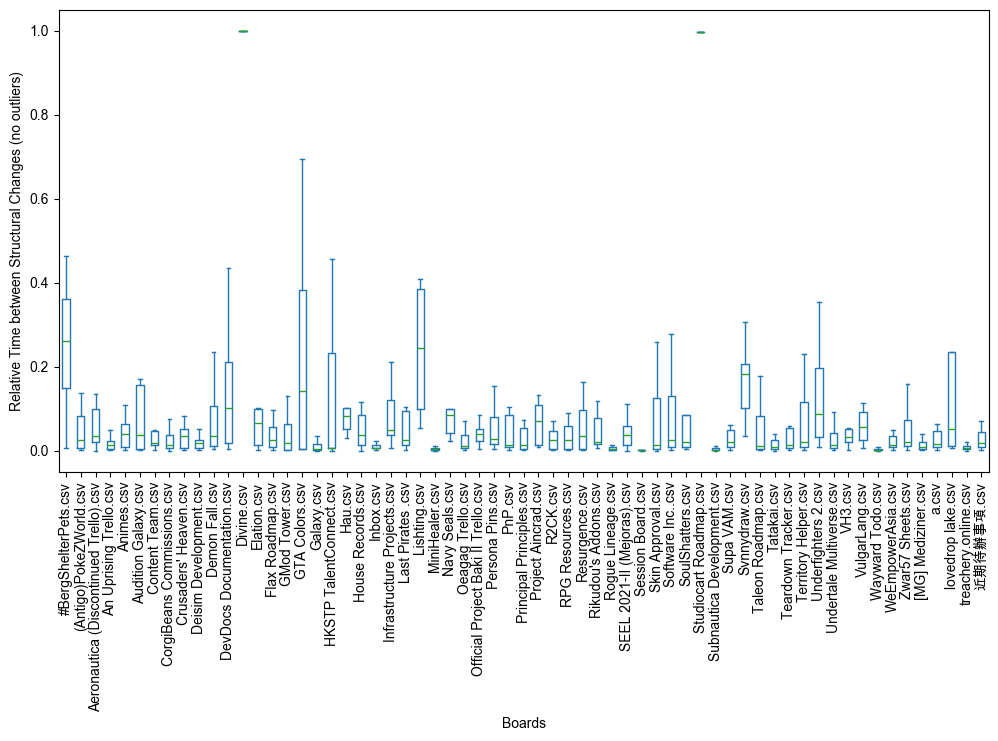

In [69]:
all_descriptions_d = []
for n, between_red, dur in zip(all_names, all_between, all_duration):
    dd = ((between_red['min'] - between_red['max']) /dur)
    #dd['label'] = n
    
    all_descriptions_d.append(pd.DataFrame({'values': dd, 'label': n}))

redesigns_description_d = pd.concat(all_descriptions_d)
redesigns_description_d

# Step 3: Plot the boxplot using pandas
redesigns_description_d.plot(kind='box', column='values', by='label', figsize=(12, 6), showfliers=False)

# Customize the plot
plt.title('')
plt.suptitle('')  # Remove the automatic title to clean up the plot
plt.xlabel('Boards')
plt.ylabel('Relative Time between Structural Changes (no outliers)')
# Step 4: Rotate x-axis labels vertically
plt.xticks(rotation=90)

# Show the plot
plt.show()



In [65]:
redesigns_description_d.groupby("label").mean().mean()

values    0.106311
dtype: float64

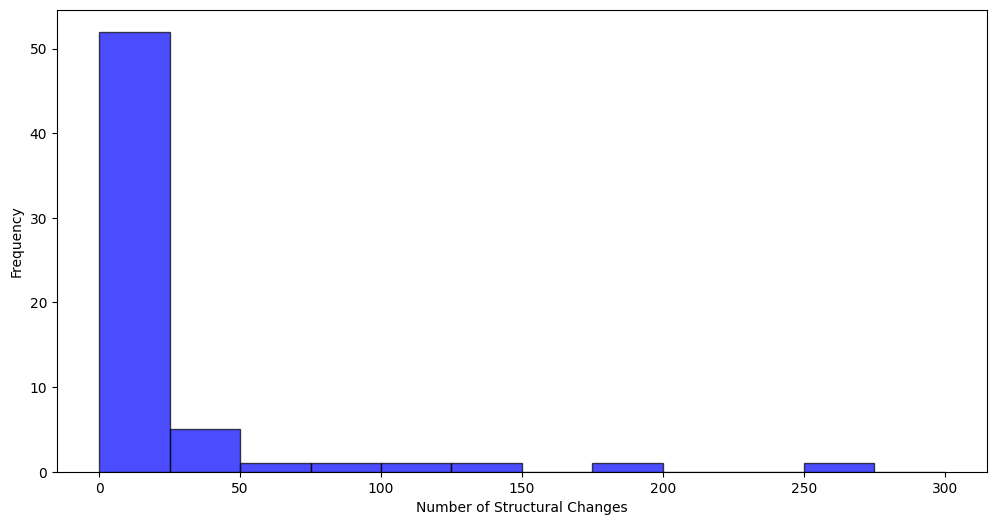

In [56]:
# Step 3: Plot the histogram
redesigns_description["count"].plot(kind='hist', bins=[0, 25, 50,75,  100,125, 150,175, 200,225, 250,275, 300], alpha=0.7, color='blue', edgecolor='black', figsize=(12, 6))

# Step 4: Customize the plot (optional)
#plt.title('Histogram of Number of Structural Changes per Board')
plt.xlabel('Number of Structural Changes')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [17]:
redesigns_description.to_csv("list_timeline.csv")

In [18]:
all_counts = []
for n, red, int in zip(all_names, all_redesigns, all_board_interval):
    # Create 10 bins between the start and end time
    bins = pd.date_range(start=int[0], end=int[1], periods=11).sort_values()

    # Cut the timestamps into these bins
    # 'right=False' makes the bins left-inclusive
    cut_series = pd.cut(red['min'], bins=bins, right=False)

    # Count the number of timestamps in each bin
    counts = cut_series.value_counts().sort_index().reset_index(drop=True)
    counts.name = n
    all_counts.append(counts)

# Display the result
evolution_moments = pd.concat(all_counts, axis=1).T
evolution_moments

,0,1,2,3,4,5,6,7,8,9
Session Board.csv,23,30,15,8,9,16,18,23,22,21
Navy Seals.csv,2,0,2,1,0,0,0,0,1,0
Subnautica Development.csv,15,42,34,18,8,8,6,9,0,1
DevDocs Documentation.csv,3,1,0,1,0,2,0,0,0,0
Rogue Lineage.csv,14,3,0,0,0,0,0,0,0,0
Tatakai.csv,9,1,6,4,1,1,0,0,0,1
a.csv,3,7,0,0,1,0,0,0,0,0
lovedrop lake.csv,4,0,0,1,0,0,0,0,0,0
treachery.online.csv,10,12,15,8,14,12,9,7,5,9
Teardown Tracker.csv,6,3,0,3,0,0,0,0,0,1


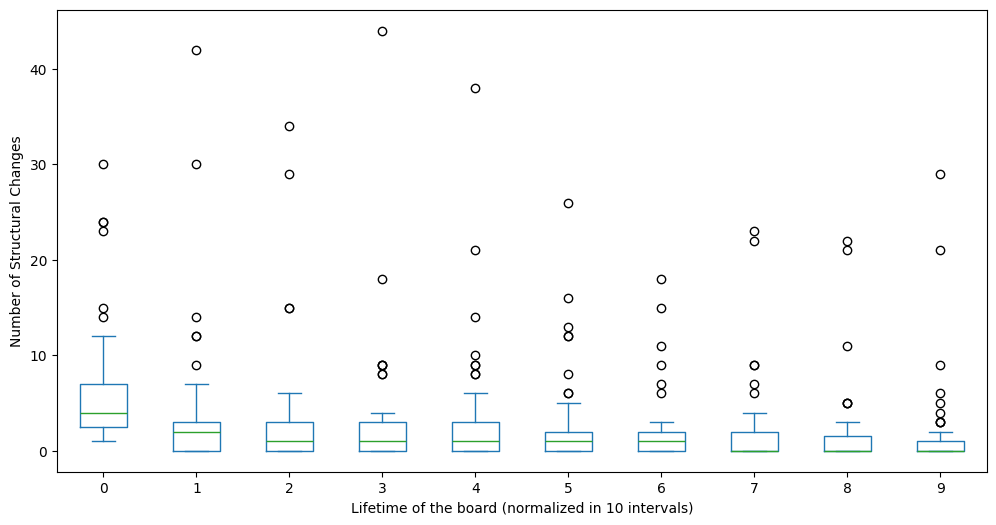

In [49]:
# Step 3: Plot the boxplot
evolution_moments.plot(kind='box', figsize=(12, 6))

# Show the plot
#plt.title('Number of Structural Changes')
plt.xlabel('Lifetime of the board (normalized in 10 intervals)')
plt.ylabel('Number of Structural Changes')
plt.show()

In [20]:
evolution_moments.to_csv("evolution_moments.csv")